<a href="https://colab.research.google.com/github/rakeshchalasani/gan-examples/blob/master/Adversarial_Feature_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

%matplotlib inline

In [0]:
from keras.layers import Input, Add, Concatenate
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten, Activation
from keras.layers import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from keras import initializers

In [0]:
K.set_image_dim_ordering('th')

# Seeding 
np.random.seed(1000)

# Dimensionality of the random vector.
randomDim = 10

# Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, np.newaxis, :, :]

In [0]:
# Define optimizer.
# opt = Adam(lr=0.005, beta_1=0.5)
opt = RMSprop(lr=0.0002, rho=0.9, epsilon=None, decay=0.000001)

In [0]:
# Generator 
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((128, 7, 7)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Convolution2D(64, kernel_size=(5, 5), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Convolution2D(1, kernel_size=(5, 5), padding='same', activation='tanh', kernel_initializer=initializers.RandomNormal(stddev=0.02)))

generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 6272)              68992     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 128, 14, 14)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 14, 14)        204864    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 64, 14, 14)        0         
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 64, 28, 28)        0         
__________

In [0]:
# Encoder
encoder = Sequential()
encoder.add(Convolution2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(1, 28, 28), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
encoder.add(LeakyReLU(0.2))
encoder.add(Dropout(0.3))
encoder.add(Convolution2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)))
encoder.add(LeakyReLU(0.2))
encoder.add(Dropout(0.3))
encoder.add(Flatten())
encoder.add(Dense(randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
encoder.add(BatchNormalization(momentum=0.8))

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 64, 14, 14)        1664      
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 64, 14, 14)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 64, 14, 14)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 128, 7, 7)         204928    
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 128, 7, 7)         0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 128, 7, 7)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6272)              0         
__________

In [0]:
# Discriminator

discriminator_image = Sequential()
discriminator_image.add(Reshape((1, 28, 28), input_shape=(28*28,)))
discriminator_image.add(Convolution2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(1, 28, 28), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator_image.add(LeakyReLU(0.2))
discriminator_image.add(Dropout(0.3))
discriminator_image.add(Convolution2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator_image.add(LeakyReLU(0.2))
discriminator_image.add(Dropout(0.3))
discriminator_image.add(Convolution2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator_image.add(LeakyReLU(0.2))
discriminator_image.add(Dropout(0.3))
discriminator_image.add(Convolution2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same', kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator_image.add(LeakyReLU(0.2))
discriminator_image.add(Dropout(0.3))
discriminator_image.add(Flatten())
discriminator_image.add(Activation('tanh'))

discriminator_image.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 14, 14)        1664      
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 64, 14, 14)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 64, 14, 14)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 7, 7)         204928    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 128, 7, 7)         0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 128, 7, 7)         0         
__________

In [0]:
# Discriminator
def disc():
  code_input = Input(shape=(randomDim,))
  image_input = Input(shape=(1, 28, 28,))
  image_out = discriminator_image(image_input)
  merged = Concatenate(axis=1)([code_input, image_out])
  l1 = Dense(1024, kernel_initializer=initializers.RandomNormal(stddev=0.02))(merged) 
  out = Dense(1, activation='sigmoid')(l1)
  return Model(inputs=[code_input, image_input], outputs=out)
  
discriminator = disc()
discriminator.compile(loss='binary_crossentropy', optimizer=opt)
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 1, 28, 28)    0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 512)          1026048     input_10[0][0]                   
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 522)          0           input_9[0][0]                    
                                                                 sequential_9[1][0]               
__________

In [0]:
# AFL
def afl1():
  discriminator.trainable = False
  aflIpCode = Input(shape=(randomDim,))
  aflIpImage = Input(shape=(1, 28, 28,))
  x = generator(aflIpCode)
  y = encoder(aflIpImage)
  codeDisOp = discriminator([aflIpCode, x])
  imageDisOp = discriminator([y, aflIpImage])
  gan = Model(inputs=[aflIpImage, aflIpCode], outputs=[imageDisOp, codeDisOp])
  gan.compile(loss='binary_crossentropy', optimizer=opt)
  return gan
gan = afl1()
gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 1, 28, 28)    0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 10)           0                                            
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 10)           269362      input_12[0][0]                   
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 1, 28, 28)    275457      input_11[0][0]                   
__________________________________________________________________________________________________
model_5 (M

In [0]:
# Create a wall of generated MNIST images
def plotGeneratedImages(examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()

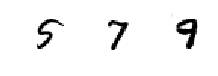

In [0]:
# Create a wall of generated MNIST images from base encoded image
def plotEncdedImages(examples=9, dim=(10, 10), figsize=(10, 10)):
    imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=2)]
    baseNoise = encoder.predict(imageBatch)
    noise = []
    noise = (baseNoise[0, :] + baseNoise[1,:])/2
    noise = noise[np.newaxis, :]
    generatedImages = np.concatenate((imageBatch, generator.predict(noise)))

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
plotEncdedImages()

In [0]:
gan.metrics_names

['loss', 'model_5_loss', 'model_5_loss']

In [0]:
dlosses = []
glosses = []
elosses = []

def train(epochs=1, batchSize=128):
    batchCount = int(X_train.shape[0] / batchSize)
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for i in range(batchCount):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise)
            images = np.concatenate([imageBatch, generatedImages])
            
            # Encode MNIST images.
            encodedCodes = encoder.predict(imageBatch)
            codes = np.concatenate([encodedCodes, noise], axis=0)

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch([codes, images], yDis)
            

            # Train generator and encoder
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch([imageBatch, noise], [yGen * 0.01, yGen * 0.9])

            if i % 100 == 0:
              dlosses.append(dloss)
              glosses.append(gloss)
#               elosses.append(eloss)
#               print("GLoss 1: %f" % gloss[1], "GLoss 2: %f" % gloss[2], "DLoss: %f" % dloss, end="\n")
              print(".",end = " ")
  
        print("\n")
        
    return []
    

In [0]:
train(200, 64)

.
.
.
.
.
.


--------------- Epoch 26 ---------------
.
.
.
.
.
.
.
.
.
.


--------------- Epoch 27 ---------------
.
.
.
.
.
.
.
.
.
.


--------------- Epoch 28 ---------------
.
.
.
.
.
.
.
.
.
.


--------------- Epoch 29 ---------------
.
.
.
.
.
.
.
.
.
.


--------------- Epoch 30 ---------------
.
.
.
.
.
.
.
.
.
.


--------------- Epoch 31 ---------------
.
.
.
.
.
.
.
.
.
.


--------------- Epoch 32 ---------------
.
.
.
.
.
.
.
.
.
.


--------------- Epoch 33 ---------------
.
.
.
.
.
.
.
.
.
.


--------------- Epoch 34 ---------------
.
.
.
.
.
.
.


KeyboardInterrupt: ignored

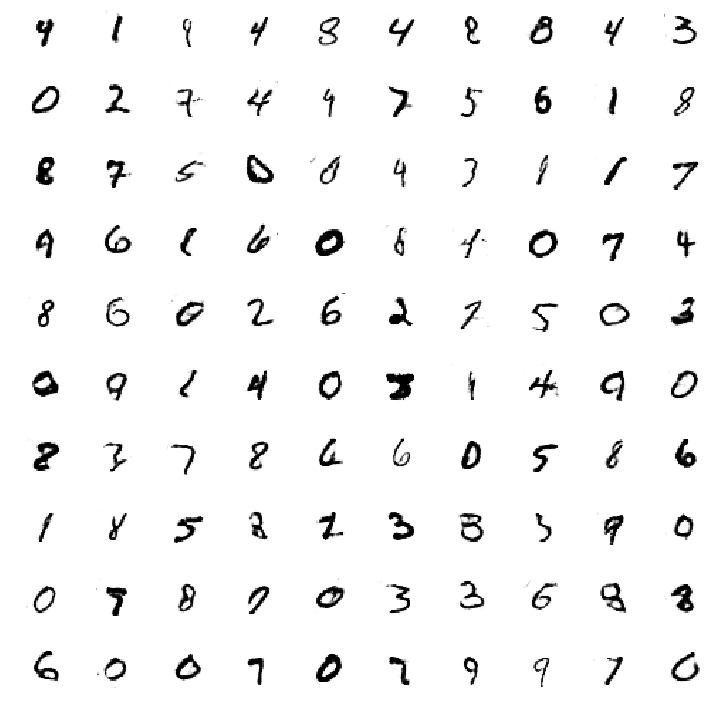

In [0]:
plotGeneratedImages()

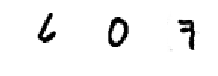

In [0]:
plotEncdedImages()

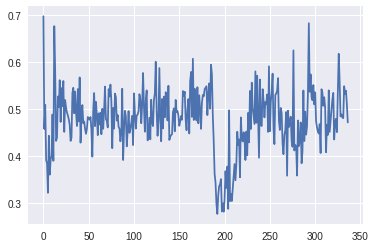

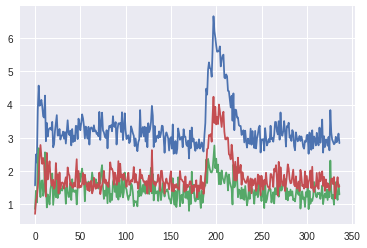

In [0]:
plt.figure()
plt.plot(dlosses)
plt.figure()
plt.plot(glosses)